In [1]:
import sys
import os
from tqdm import tqdm
import pandas as pd
import json
import matplotlib.pyplot as plt
import random

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from visual_genome.local import VisualGenome
from visual_genome.local import VrRVG

C:\Users\karab\AppData\Local\Temp\ipykernel_11588\836405357.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
vg = VisualGenome()

Script directory: C:\Users\karab\Desktop\Visual Genome Driver\visual_genome
Data directory: C:\Users\karab\Desktop\Visual Genome Driver\data
Loading data...


In [ ]:
# read categories_all-mpnet-base-v2_80clusters_simple.csv
# map each id to a category

categories = {}
with open('categories_all-mpnet-base-v2_80clusters_simple.csv', 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        # ignore the header
        if line.startswith('Image_id'):
            continue
        cat_id, cat_name = line.split(',')
        categories[int(cat_id)] = cat_name

In [ ]:
df = pd.read_csv('categories_all-mpnet-base-v2_80clusters_simple.csv')

In [ ]:
vg.visualize_cluster(df, cluster = 8, n = 3)

In [ ]:
# get images in a cluster
def get_images_in_cluster(cluster_id):
    images = []
    for i in range(len(df)):
        if df['cluster'][i] == cluster_id:
            images.append(df['Image_id'][i])
    return images

cluster_5_images = get_images_in_cluster(5)
len(cluster_5_images)

In [ ]:
object_means = {}
attribute_means = {}
relationships_means = {}

# get list of clusters:
clusters = list(set(df['cluster']))

In [ ]:
for cluster in clusters:
    cluster_images = get_images_in_cluster(cluster)
    obj_mean = vg.histogram('objects', cluster_images)
    attr_mean = vg.histogram('attributes', cluster_images)
    rel_mean = vg.histogram('relationships', cluster_images)
    
    object_means[cluster] = obj_mean
    attribute_means[cluster] = attr_mean
    relationships_means[cluster] = rel_mean
    
    print(f'Cluster {cluster} done')

In [ ]:
# find minimum of object_means
min_obj = float('inf')
min_obj_cluster = None

max_obj = 0
max_obj_cluster = None
for cluster in clusters:
    if object_means[cluster] < min_obj:
        min_obj = object_means[cluster]
        min_obj_cluster = cluster
    if object_means[cluster] > max_obj:
        max_obj = object_means[cluster]
        max_obj_cluster = cluster
        

In [ ]:
min_obj_cluster, min_obj

In [ ]:
vg.visualize_cluster(df, cluster = min_obj_cluster, n = 3)

In [ ]:
max_obj_cluster, max_obj

In [ ]:
vg.visualize_cluster(df, cluster = max_obj_cluster, n = 3)

In [ ]:
def find_connected_components(im):
    objects = vg.get_image_objects(im)
    relationships = vg.get_image_relationships(im)

    graph = {}
    for obj in objects:
        graph[obj.id] = []

    for rel in relationships:
        graph[rel.subject_id].append(rel.object_id)
        graph[rel.object_id].append(rel.subject_id)

    visited = set()
    components = 0
    for obj in objects:
        if obj.id not in visited:
            components += 1
            stack = [obj.id]
            while stack:
                node = stack.pop()
                if node not in visited:
                    visited.add(node)
                    stack.extend(graph[node])

    return components


In [ ]:
# map images to connected components

image_to_cc = {}
for i in tqdm(range(len(df))):
    image_id = df['Image_id'][i]
    cc = find_connected_components(image_id)
    image_to_cc[image_id] = cc

In [ ]:
# create a histogram out of image_to_cc

cc_hist = {}
for image_id, cc in image_to_cc.items():
    if cc not in cc_hist:
        cc_hist[cc] = 0
    cc_hist[cc] += 1

# plot
import matplotlib.pyplot as plt

plt.bar(cc_hist.keys(), cc_hist.values())
plt.xlabel('Connected components')
plt.ylabel('Number of images')
plt.title('Connected components histogram')
plt.show()

In [ ]:
def graphviz(image):
    scene_graph = vg.generate_scene_graph_json(image)

    # save to graph.json
    with open(f"../graphviz/scene_graph.json", "w") as f:
        json.dump(scene_graph, f)

    # run the following command to visualize the scene graph
    # python ../graphviz/visualize_scene_graph.py


In [ ]:
suitable_images = {}

for cluster in clusters:
    suitable_images[cluster] = []
    objs_map = {}
    rels_map = {}
    cc_map = {}
    for id in get_images_in_cluster(cluster):
        objs_map[id] = len(vg.get_image_objects(id))
        rels_map[id] = len(vg.get_image_relationships(id))
        cc_map[id] = image_to_cc[id]
    
    # sort by number of objects
    sorted_objs = sorted(objs_map.items(), key=lambda x: x[1])
    sorted_rels = sorted(rels_map.items(), key=lambda x: x[1])
    
    # get 50% and 75% percentiles
    def get_interval(list_, p1, p2):
        n = len(list_)
        lo = n*p1//100
        hi = n*p2//100
        
        return list_[lo:hi]
    
    obj_interval = get_interval(sorted_objs, 25, 100)
    rel_interval = get_interval(sorted_rels, 25, 100)
    
    
    
    # get intersection of all three based on keys
    obj_keys = set([x[0] for x in obj_interval])
    rel_keys = set([x[0] for x in rel_interval])
    
    candidates = list(obj_keys.intersection(rel_keys))
    # remove images with more than 5 connected components
    for id in candidates:
        if cc_map[id] <= 10:
            suitable_images[cluster].append(id)
    
    
    
    print(f'Cluster {cluster} done')
    

In [ ]:
suitables = []
for cluster in clusters:
    suitables.extend(suitable_images[cluster])
print(len(suitables))

In [ ]:
vg.histogram('objects', suitables)
vg.histogram('attributes', suitables)
vg.histogram('relationships', suitables)

In [ ]:
vg.load_sam_results('sam.json')

In [ ]:
# select a cluster randomly
import random
cluster = random.choice(clusters)
# select an image randomly
image = random.choice(suitable_images[cluster])
graphviz(image)

In [ ]:
diffs = {}
for cluster in clusters:
    ims = suitable_images[cluster]
    for im in ims:
        objs = len(vg.get_image_objects(im))
        #sam = vg.get_sam_segmentations(im)
        sam = vg.SAM[im]
        diff = abs(objs - sam)
        diffs[im] = diff

In [ ]:
# histogram of differences
import matplotlib.pyplot as plt
plt.hist(diffs.values(), bins=20)
plt.show()

In [ ]:
len(suitables)

In [ ]:
# get features.csv
df_feat = pd.read_csv('features.csv')

# get correlation of all features on a heatmap
# create a heatmap of correlations between all features
df_feat["avg_object_similarity"] *= -1
df_feat["avg_region_similarity"] *= -1
df_feat["avg_rel_similarity"] *= -1

In [ ]:
# print correlations between features and complexity

def print_cors(df_feat):
    print(df_feat['predicted_complexity'].corr(df_feat['# of SAM 2 segmentations'], method='spearman'))
    print(df_feat['predicted_complexity'].corr(df_feat['# of SAM segmentations'], method='spearman'))
    print(df_feat['predicted_complexity'].corr(df_feat['# of FC-CLIP classes'], method='spearman'))
    print(df_feat['predicted_complexity'].corr(df_feat['avg_object_similarity'], method='spearman'))
    print(df_feat['predicted_complexity'].corr(df_feat['avg_region_similarity'], method='spearman'))
    print(df_feat['predicted_complexity'].corr(df_feat['avg_rel_similarity'], method='spearman'))


In [ ]:
# get only the images in suitables
df_new = df_feat[df_feat['image_id'].isin(suitables)]
print_cors(df_new)

In [ ]:
# subsample 1000 images
import random

sample = random.sample(list(df_new['image_id']), 1000)
df_sample = df_new[df_new['image_id'].isin(sample)]

print_cors(df_sample)

In [ ]:
# write to txt
with open('candidate_sample_3.txt', 'w') as f:
    for item in sample:
        f.write("%s\n" % item)

## Filtering

Filtering based on number of relationships

In [2]:
vg = VisualGenome()
vrrvg = VrRVG()

Script directory: C:\Users\karab\Desktop\Visual Genome Driver\visual_genome
Data directory: C:\Users\karab\Desktop\Visual Genome Driver\data
Loading data...
Data loaded.
Script directory: C:\Users\karab\Desktop\Visual Genome Driver\visual_genome
Data directory: C:\Users\karab\Desktop\Visual Genome Driver\data\VrR-VG
Loading data...
Data loaded.


In [3]:
pool = vrrvg.get_images()

In [4]:
im_to_rel_vrrvg = {}
im_to_rel_vg = {}

for im in pool:
    rels_by_vrrvg = len(vrrvg.get_image_relationships(im))
    rels_by_vg = len(vg.get_image_relationships(im))
    
    im_to_rel_vrrvg[im] = rels_by_vrrvg
    im_to_rel_vg[im] = rels_by_vg

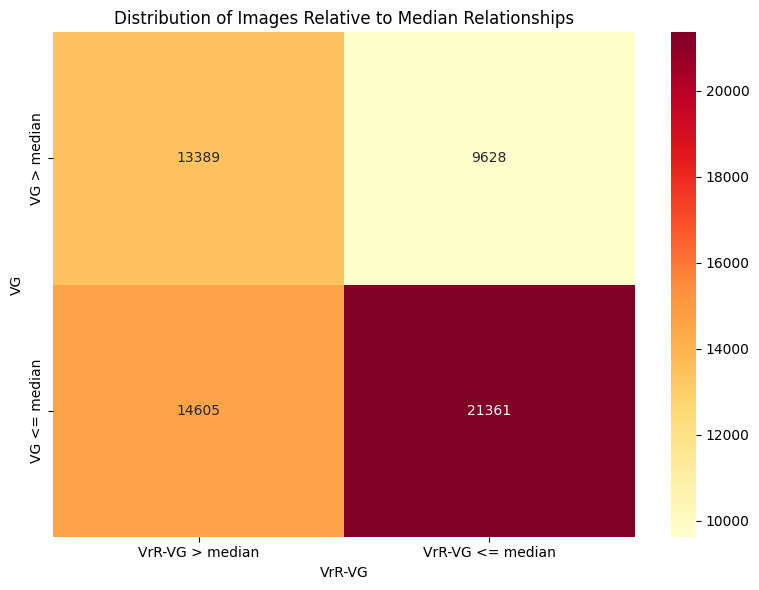

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming these calculations are correct
median_vrrvg = sorted(im_to_rel_vrrvg.values())[len(im_to_rel_vrrvg)//2]
median_vg = sorted(im_to_rel_vg.values())[len(im_to_rel_vg)//2]

both_higher = 0
both_lower = 0
vrrvg_higher = 0
vg_higher = 0

for im in pool:
    if im_to_rel_vrrvg[im] > median_vrrvg and im_to_rel_vg[im] > median_vg:
        both_higher += 1
    elif im_to_rel_vrrvg[im] <= median_vrrvg and im_to_rel_vg[im] <= median_vg:
        both_lower += 1
    elif im_to_rel_vrrvg[im] > median_vrrvg:
        vrrvg_higher += 1
    else:
        vg_higher += 1

# Create the 2x2 matrix
data = [
    [both_higher, vrrvg_higher],  # First row: VG ≥ median
    [vg_higher, both_lower]       # Second row: VG < median
]

# Create DataFrame with clear labels
df = pd.DataFrame(
    data,
    index=['VG > median', 'VG <= median'],
    columns=['VrR-VG > median', 'VrR-VG <= median']
)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, fmt='d', cmap='YlOrRd')
plt.xlabel('VrR-VG')
plt.ylabel('VG')
plt.title('Distribution of Images Relative to Median Relationships')
plt.tight_layout()
plt.show()

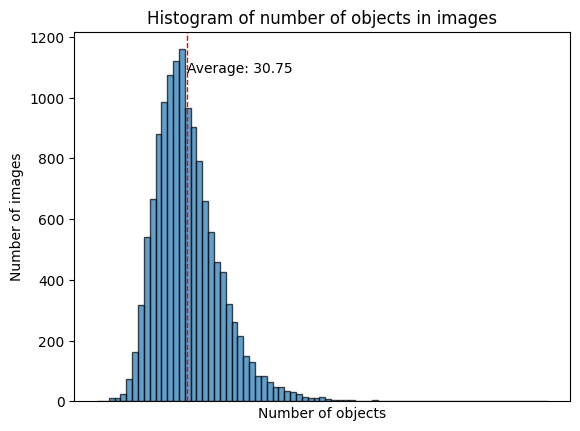

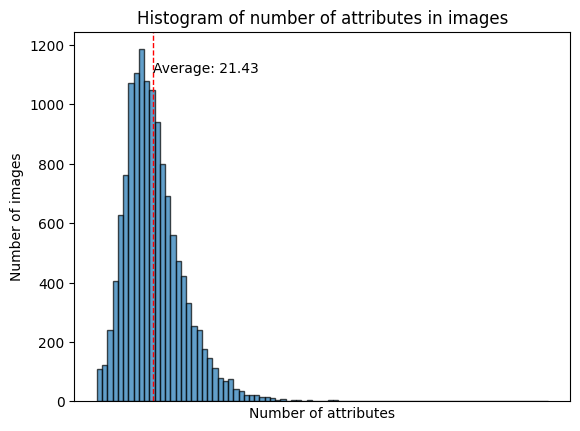

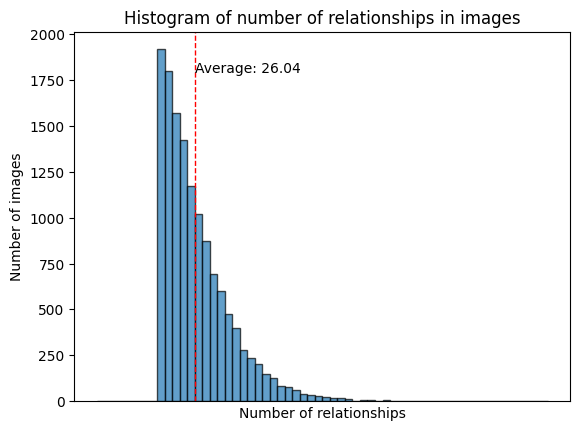

26.039883486444097

In [6]:
# get images from the first quadrant

quadrant_1 = [im for im in pool if im_to_rel_vg[im] > median_vg and im_to_rel_vrrvg[im] > median_vrrvg]
vg.histogram('objects', quadrant_1)
vg.histogram('attributes', quadrant_1)
vg.histogram('relationships', quadrant_1)

In [7]:
# get x-(100-x) percentile of quadrant_1 based on number of objects
objs_map = {}

for id in quadrant_1:
    objs_map[id] = len(vg.get_image_objects(id))
    
sorted_objs = sorted(objs_map.items(), key=lambda x: x[1])

def get_interval(list_, p1, p2):
    n = len(list_)
    lo = n*p1//100
    hi = n*p2//100

    tuples = list_[lo:hi]
    return [x[0] for x in tuples]

quadrant_1_reduced = get_interval(sorted_objs, 5, 95)
len(quadrant_1_reduced)

12050

Text(0, 0.5, 'Number of images with different object counts')

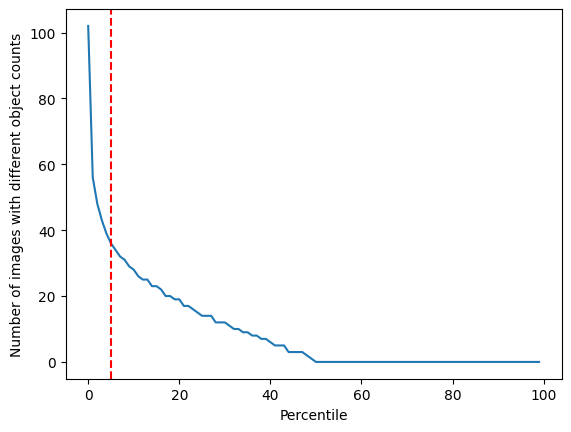

In [8]:
graph = []
for int in range(0, 100):
    quadrant_reduced = get_interval(sorted_objs, int, 100-int)
    obs_to_im = {}
    for im in quadrant_reduced:
        obs = len(vg.get_image_objects(im))
        
        if obs not in obs_to_im:
            obs_to_im[obs] = []
        obs_to_im[obs].append(im)
    graph.append(len( list(obs_to_im.keys())))

plt.plot(graph)
# mark the point where x = 5
plt.axvline(x=5, color='r', linestyle='--')
plt.xlabel('Percentile')
plt.ylabel('Number of images with different object counts')



In [9]:
obs_to_im = {}
for im in quadrant_1_reduced:
    obs = len(vg.get_image_objects(im))
    
    if obs not in obs_to_im:
        obs_to_im[obs] = []
    obs_to_im[obs].append(im)

In [10]:
keys = list(obs_to_im.keys())
sorted_keys = sorted(keys)
len(sorted_keys)

36

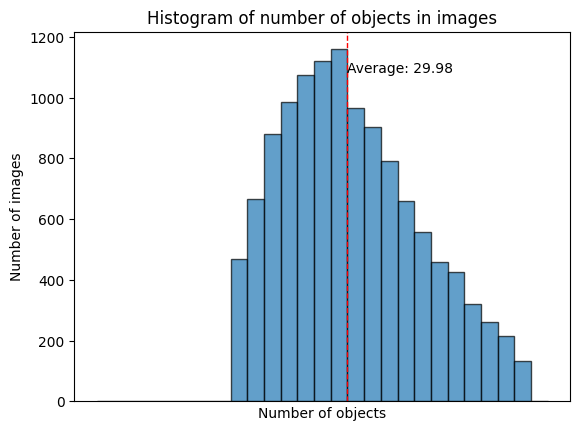

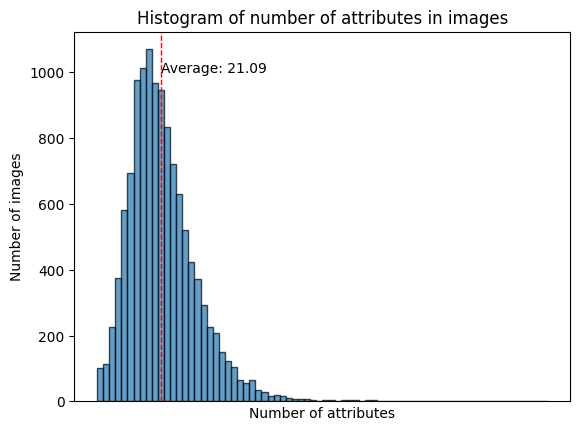

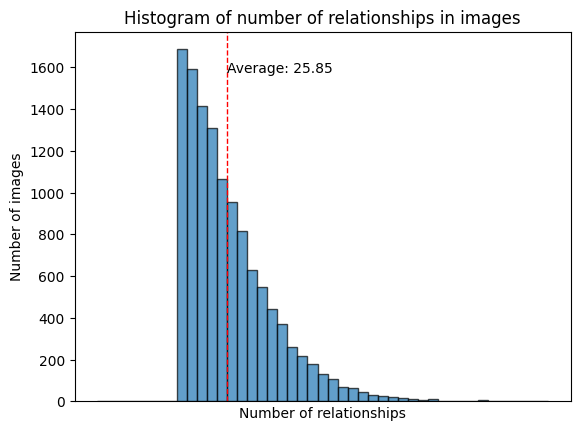

25.85203319502075

In [11]:
vg.histogram('objects', quadrant_1_reduced)
vg.histogram('attributes', quadrant_1_reduced)
vg.histogram('relationships', quadrant_1_reduced)

In [12]:
vg.load_fc_clip_results()
vg.load_sam_results(version=1)
vg.load_sam_results(version=2)

{'2398495': 31,
 '2335940': 8,
 '2365833': 43,
 '2388196': 22,
 '2342996': 26,
 '2368569': 23,
 '2349498': 31,
 '2375891': 20,
 '2329434': 16,
 '2352696': 14,
 '2409167': 7,
 '2394130': 6,
 '2359458': 32,
 '2334050': 5,
 '2335546': 82,
 '2370352': 1,
 '1592472': 184,
 '2394261': 5,
 '2392895': 18,
 '2332898': 17,
 '2399014': 66,
 '2320802': 29,
 '2350229': 98,
 '2359663': 6,
 '2393483': 50,
 '2335836': 5,
 '2400806': 8,
 '2404495': 27,
 '2336176': 25,
 '2401176': 20,
 '2388246': 11,
 '2398913': 26,
 '2342164': 20,
 '2357179': 13,
 '2326961': 26,
 '2401170': 18,
 '2382595': 10,
 '2372874': 11,
 '2338997': 18,
 '2359223': 27,
 '2385528': 45,
 '2391248': 12,
 '551': 25,
 '2350964': 34,
 '2360116': 33,
 '2376189': 8,
 '2397487': 3,
 '2356216': 33,
 '2363236': 9,
 '2402100': 14,
 '2336624': 9,
 '713558': 136,
 '2368648': 4,
 '2342521': 33,
 '2318299': 14,
 '2343381': 72,
 '2407542': 8,
 '933': 25,
 '2345701': 11,
 '96': 48,
 '2395344': 16,
 '2331203': 45,
 '2364591': 16,
 '2349218': 14,
 '2

In [13]:
def randomly_visualize(vg, n=1, include_regions=False, ims = None):
    if ims is None:
        ims = vg.get_image_ids()
    for i in range(n):
        im = random.choice(ims)
        scene_graph = vg.generate_scene_graph_json(im, include_regions=include_regions)

        # save to graph.json
        if i >= 1:
            filename = f"../graphviz/scene_graph{i}.json"
        else:
            filename = f"../graphviz/scene_graph.json"
        with open(filename, "w") as f:
            json.dump(scene_graph, f)
    COUNT = n
    !python ../graphviz/visualize_scene_graph.py -n {COUNT}

In [14]:
COUNT = 10
INCLUDE_REGIONS = True

In [54]:
randomly_visualize(vg, n=COUNT, include_regions=INCLUDE_REGIONS, ims=quadrant_1_reduced)

In [15]:
def get_correlations(ims):
    im_to_obj_vg = {}
    im_to_obj_sam = {}
    im_to_pred_complexity = {}
    im_to_reg_sim = {}
    im_to_rel_sim = {}
    im_to_fc_clip = {}

    df_feat = pd.read_csv('features.csv')

    for im in ims:
        objs = vg.get_image_objects(im)
        im_to_obj_vg[im] = len(objs)
        im_to_obj_sam[im] = vg.SAM[im]
        im_to_fc_clip[im] = vg.FC_CLIP[im]
        im_to_pred_complexity[im] = df_feat[df_feat['image_id'] == im]['predicted_complexity'].values[0]
        im_to_reg_sim[im] = df_feat[df_feat['image_id'] == im]['avg_region_similarity'].values[0]
        im_to_rel_sim[im] = df_feat[df_feat['image_id'] == im]['avg_rel_similarity'].values[0]
    
    objs = list(im_to_obj_vg.values())
    sam = list(im_to_obj_sam.values())
    complexity = list(im_to_pred_complexity.values())
    rels = list(im_to_rel_sim.values())
    regs = list(im_to_reg_sim.values())
    fcclip = list(im_to_fc_clip.values())

    # correlation
    import numpy as np
    corr_objs_complexity = np.corrcoef(objs, complexity)[0, 1]
    corr_sam_complexity = np.corrcoef(sam, complexity)[0, 1]
    corr_rel_complexity = -np.corrcoef(rels, complexity)[0, 1]
    corr_reg_complexity = -np.corrcoef(regs, complexity)[0, 1]
    fcclip_complexity = np.corrcoef(fcclip, complexity)[0, 1]

    print("Correlation between number of objects and complexity:", corr_objs_complexity)
    print("Correlation between number of SAM segmentations and complexity:", corr_sam_complexity)
    print("Correlation between region similarity and complexity:", corr_rel_complexity)
    print("Correlation between relationship similarity and complexity:", corr_reg_complexity)
    print("Correlation between FC-CLIP classes and complexity:", fcclip_complexity)

    return im_to_obj_vg, im_to_obj_sam, im_to_pred_complexity, im_to_reg_sim, im_to_rel_sim

In [28]:
def analyze_aspect_ratios(images, target_width=400, target_height=300, show_stats=True):
    target_ratio = target_height / target_width  # 0.75 for 400x300
    
    # Initialize containers for analysis
    aspect_stats = {
        'ratios': [],
        'dimensions': set(),
        'distortion_levels': []
    }
    
    # Calculate distortion levels for different tolerances
    tolerances = [0.1, 0.15, 0.2, 0.25, 0.3]
    images_per_tolerance = {t: [] for t in tolerances}
    
    for img in images:
        det = vg.get_image(img)
        img_ratio = det.height / det.width
        aspect_stats['ratios'].append(img_ratio)
        aspect_stats['dimensions'].add((det.height, det.width))
        
        # Calculate distortion level (how much the image would be stretched/squeezed)
        distortion = abs(img_ratio - target_ratio) / target_ratio * 100
        aspect_stats['distortion_levels'].append(distortion)
        
        # Check which tolerance levels this image would pass
        for tolerance in tolerances:
            if abs(img_ratio - target_ratio) < tolerance:
                images_per_tolerance[tolerance].append(img)
    
    if show_stats:
        print(f"Target aspect ratio (height/width): {target_ratio:.3f}")
        print(f"\nUnique image dimensions (height, width): ")
        for dim in sorted(aspect_stats['dimensions']):
            print(f"{dim} - ratio: {dim[0]/dim[1]:.3f}")
        
        print("\nImages retained at different tolerance levels:")
        for tolerance in tolerances:
            retained = len(images_per_tolerance[tolerance])
            percent = (retained / len(images)) * 100
            print(f"Tolerance {tolerance:.2f}: {retained}/{len(images)} images ({percent:.1f}%)")
        
        print(f"\nDistortion statistics:")
        print(f"Average distortion: {sum(aspect_stats['distortion_levels'])/len(aspect_stats['distortion_levels']):.1f}%")
        print(f"Max distortion: {max(aspect_stats['distortion_levels']):.1f}%")
    
    return images_per_tolerance

# Run the analysis
results = analyze_aspect_ratios(quadrant_1_reduced)

# Choose a reasonable tolerance based on the analysis
# For example, if you want to keep ~80% of images:
reasonable_tolerance = 0.25  # Adjust based on the analysis results

# Filter images with the chosen tolerance
# width=400 height=300
target_ratio = 300/400  # 0.75 for 400x300
size_filtered_images = [
    img for img in quadrant_1_reduced
    if abs(vg.get_image(img).height / vg.get_image(img).width - target_ratio) < reasonable_tolerance
]

print(f"\nFinal filtered set: {len(size_filtered_images)}/{len(quadrant_1_reduced)} images retained")

Target aspect ratio (height/width): 0.750

Unique image dimensions (height, width): 
(110, 500) - ratio: 0.220
(119, 500) - ratio: 0.238
(120, 160) - ratio: 0.750
(126, 210) - ratio: 0.600
(129, 500) - ratio: 0.258
(132, 500) - ratio: 0.264
(134, 500) - ratio: 0.268
(144, 176) - ratio: 0.818
(148, 500) - ratio: 0.296
(151, 500) - ratio: 0.302
(157, 500) - ratio: 0.314
(165, 500) - ratio: 0.330
(167, 500) - ratio: 0.334
(170, 500) - ratio: 0.340
(172, 500) - ratio: 0.344
(173, 500) - ratio: 0.346
(176, 500) - ratio: 0.352
(178, 500) - ratio: 0.356
(180, 240) - ratio: 0.750
(183, 500) - ratio: 0.366
(185, 500) - ratio: 0.370
(187, 500) - ratio: 0.374
(188, 500) - ratio: 0.376
(189, 500) - ratio: 0.378
(195, 500) - ratio: 0.390
(198, 500) - ratio: 0.396
(200, 500) - ratio: 0.400
(202, 500) - ratio: 0.404
(203, 500) - ratio: 0.406
(204, 500) - ratio: 0.408
(205, 500) - ratio: 0.410
(206, 500) - ratio: 0.412
(207, 375) - ratio: 0.552
(208, 500) - ratio: 0.416
(212, 500) - ratio: 0.424
(213,

In [29]:
quadrant_1_reduced = size_filtered_images

Correlation between number of objects and complexity: 0.38417429723658736
Correlation between number of SAM segmentations and complexity: 0.7868783695950567
Correlation between region similarity and complexity: 0.277725133888404
Correlation between relationship similarity and complexity: 0.2850322123853121
Correlation between FC-CLIP classes and complexity: 0.5400991186973552


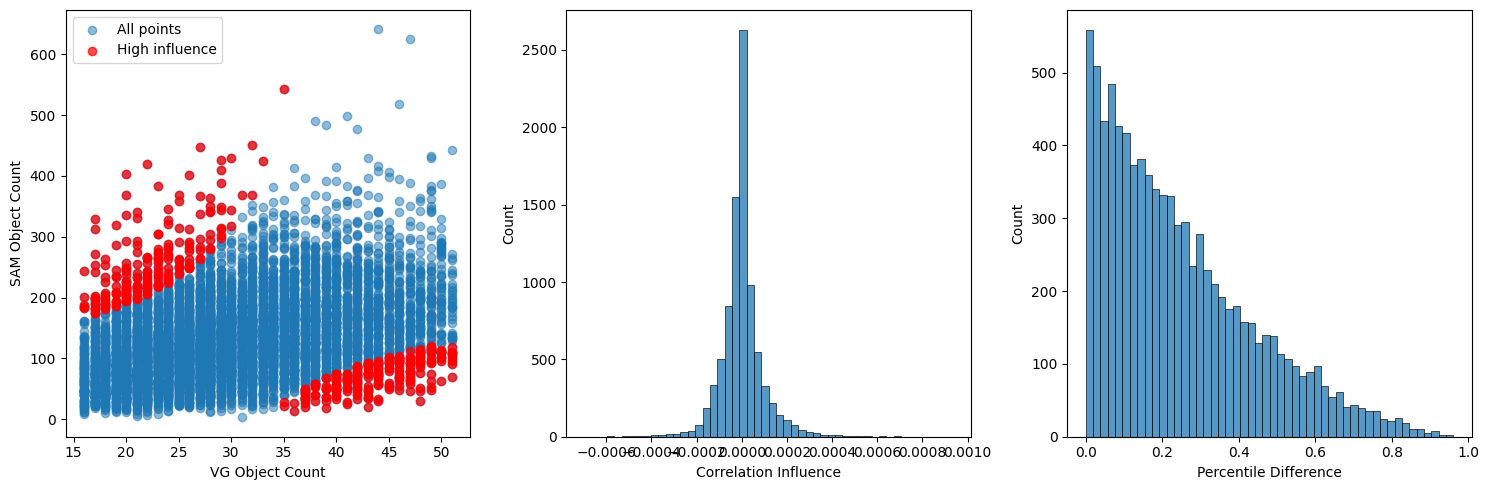

Original correlation: 0.394

Top 10 correlation-reducing points:
      image_id  influence  VG Object Count  SAM Object Count
1027   2380938   0.000934               20               404
1790   2353192   0.000883               22               420
1022   2381822   0.000777               20               369
329    2322630   0.000753               17               329
319    2335912   0.000682               17               313
2205   2320091   0.000676               23               384
3562   2384773   0.000673               27               447
1038   2379128   0.000637               20               335
709    2387364   0.000622               19               320
1302   2388584   0.000613               21               341

Extreme cases (95th percentile of influence):
      image_id  VG Object Count  SAM Object Count  influence
1027   2380938               20               404   0.000934
1790   2353192               22               420   0.000883
1022   2381822               20   

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_correlation(data1, data2, ids, label1="Measure 1", label2="Measure 2", save_csv=False):
    """
    Analyze correlation between two measurements and identify influential points.
    
    Args:
        data1 (array-like): First measurement values
        data2 (array-like): Second measurement values
        ids (array-like): Identifiers for each data point
        label1 (str): Label for first measurement (used in plots and output)
        label2 (str): Label for second measurement (used in plots and output)
        save_csv (bool): Whether to save results to CSV
        
    Returns:
        pd.DataFrame: Results of the analysis
        dict: Summary statistics and high influence cases
    """
    # Convert inputs to numpy arrays
    data1 = np.array(data1)
    data2 = np.array(data2)
    ids = np.array(ids)
    
    # Calculate baseline correlation
    baseline_corr = stats.pearsonr(data1, data2)[0]
    
    # Calculate influences
    influences = []
    for i in range(len(ids)):
        mask = np.ones(len(ids), dtype=bool)
        mask[i] = False
        
        new_corr = stats.pearsonr(data1[mask], data2[mask])[0]
        influence = new_corr - baseline_corr
        
        influences.append({
            'image_id': ids[i],
            f'{label1}': data1[i],
            f'{label2}': data2[i],
            'influence': influence,
            'ratio': data1[i] / data2[i] if data2[i] != 0 else float('inf')
        })
    
    # Create DataFrame and add percentile information
    df = pd.DataFrame(influences)
    df = df.sort_values('influence', ascending=False)
    df[f'{label1}_percentile'] = pd.Series(data1).rank(pct=True)
    df[f'{label2}_percentile'] = pd.Series(data2).rank(pct=True)
    df['percentile_diff'] = abs(df[f'{label1}_percentile'] - df[f'{label2}_percentile'])
    
    # Find interesting cases
    high_influence = df[df['influence'] > df['influence'].quantile(0.95)]
    different_values = df[df['percentile_diff'] > 0.8]
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Scatter plot with highlighted influential points
    plt.subplot(131)
    plt.scatter(data1, data2, alpha=0.5, label='All points')
    influential_mask = df['influence'] > df['influence'].quantile(0.95)
    plt.scatter(df[influential_mask][label1], 
                df[influential_mask][label2], 
                color='red', alpha=0.7, label='High influence')
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.legend()
    
    # Plot 2: Distribution of influences
    plt.subplot(132)
    sns.histplot(df['influence'], bins=50)
    plt.xlabel('Correlation Influence')
    plt.ylabel('Count')
    
    # Plot 3: Percentile difference distribution
    plt.subplot(133)
    sns.histplot(df['percentile_diff'], bins=50)
    plt.xlabel('Percentile Difference')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Original correlation: {baseline_corr:.3f}")
    print(f"\nTop 10 correlation-reducing points:")
    print(df[['image_id', 'influence', label1, label2]].head(10))
    print(f"\nExtreme cases (95th percentile of influence):")
    print(high_influence[['image_id', label1, label2, 'influence']].head())
    
    # Save results if requested
    if save_csv:
        filename = f'correlation_analysis_{label1}_{label2}.csv'.replace(' ', '_').lower()
        df.to_csv(filename, index=False)
        print(f"\nResults saved to {filename}")
    
    # Return results and summary
    summary = {
        'baseline_correlation': baseline_corr,
        'high_influence_cases': high_influence,
        'different_values': different_values
    }
    
    return df, summary

image_ids = np.array(quadrant_1_reduced)

im_to_obj_vg, im_to_obj_sam, im_to_pred_complexity, im_to_reg_sim, im_to_rel_sim = get_correlations(image_ids)

vg_counts = np.array([im_to_obj_vg[img] for img in image_ids])
sam_counts = np.array([im_to_obj_sam[img] for img in image_ids])
avg_reg_similarity = np.array([im_to_reg_sim[img] for img in image_ids])
avg_rel_similarity = np.array([im_to_rel_sim[img] for img in image_ids])

# Example usage:
# For VG counts vs SAM counts:
results_df, summary = analyze_correlation(
     vg_counts, 
     sam_counts, 
     image_ids, 
     label1="VG Object Count", 
     label2="SAM Object Count",
     save_csv=True)

# For VG counts vs reg similarity:
# results_df, summary = analyze_correlation(
#     vg_counts, 
#     avg_reg_similarity, 
#     image_ids, 
#     label1="VG Object Count", 
#     label2="Avg Region Similarity"
# )

In [51]:
import pandas as pd
from scipy import stats


def filter_out(csv, label1, label2, threshold_percentile=10):
    # Read the analysis results
    analysis_df = pd.read_csv(csv)

    # There are several approaches we could take to filter:

    def filter_by_influence(analysis_df, threshold_percentile=threshold_percentile):
        """Filter out images with high negative influence on correlation"""
        # Get influence threshold (positive influence means correlation would increase if removed)
        threshold = analysis_df['influence'].quantile(threshold_percentile/100)
        
        # Keep images that don't heavily decrease correlation
        keep_images = analysis_df[analysis_df['influence'] <= threshold]['image_id'].tolist()
        return keep_images

    def filter_by_percentile_diff(analysis_df, threshold=threshold_percentile):
        """Filter out images where VG and SAM counts are very different in terms of percentiles"""
        keep_images = analysis_df[analysis_df['percentile_diff'] <= threshold]['image_id'].tolist()
        return keep_images

    # Let's try both approaches and compare results
    keep_images_influence = filter_by_influence(analysis_df)
    keep_images_percentile = filter_by_percentile_diff(analysis_df)

    # Intersection of both filters for stricter filtering
    keep_images_strict = list(set(keep_images_influence) & set(keep_images_percentile))

    # Print statistics
    print(f"Original number of images: {len(analysis_df)}")
    print(f"Images after influence filter: {len(keep_images_influence)}")
    print(f"Images after percentile difference filter: {len(keep_images_percentile)}")
    print(f"Images after both filters: {len(keep_images_strict)}")

    # Calculate correlations with different filtering approaches
    def calculate_filtered_correlation(analysis_df, keep_images):
        filtered_df = analysis_df[analysis_df['image_id'].isin(keep_images)]
        correlation = stats.pearsonr(filtered_df[label1], filtered_df[label2])[0]
        return correlation

    original_correlation = stats.pearsonr(analysis_df[label1], analysis_df[label2])[0]
    influence_correlation = calculate_filtered_correlation(analysis_df, keep_images_influence)
    percentile_correlation = calculate_filtered_correlation(analysis_df, keep_images_percentile)
    strict_correlation = calculate_filtered_correlation(analysis_df, keep_images_strict)

    print("\nCorrelations:")
    print(f"Original: {original_correlation:.3f}")
    print(f"After influence filter: {influence_correlation:.3f}")
    print(f"After percentile difference filter: {percentile_correlation:.3f}")
    print(f"After both filters: {strict_correlation:.3f}")

    # Save the filtered image lists
    filtered_results = {
        'image_id': keep_images_influence,
        'filter_method': 'influence'
    }
    filtered_df = pd.DataFrame(filtered_results)
    filtered_df.to_csv('filtered_images.csv', index=False)

    # print number of images
    print(len(keep_images_influence))
    print("\nFiltered image list saved to 'filtered_images.csv'")
    return keep_images_influence

keep_images_influence = filter_out("correlation_analysis_vg_object_count_sam_object_count.csv", 'VG Object Count', 'SAM Object Count', threshold_percentile=11.3)
# keep_images_influence = filter_out(results_df, 'VG Object Count', 'Avg Region Similarity', threshold_percentile=8.5)

Original number of images: 8840
Images after influence filter: 1002
Images after percentile difference filter: 8840
Images after both filters: 1002

Correlations:
Original: 0.394
After influence filter: 0.896
After percentile difference filter: 0.394
After both filters: 0.896
1002

Filtered image list saved to 'filtered_images.csv'


In [32]:
randomly_visualize(vg, n=10, include_regions=True, ims=keep_images_influence)

In [52]:
# measure correlations 
get_correlations(keep_images_influence)

Correlation between number of objects and complexity: 0.8556840922715547
Correlation between number of SAM segmentations and complexity: 0.8850599619272311
Correlation between region similarity and complexity: 0.4882398529692828
Correlation between relationship similarity and complexity: 0.4775792655549203
Correlation between FC-CLIP classes and complexity: 0.7240879004681617


({2371865: 21,
  2383254: 21,
  2352064: 21,
  2398867: 21,
  2343646: 21,
  2388981: 50,
  2334187: 19,
  2382135: 19,
  2359999: 38,
  2356841: 22,
  2395400: 22,
  2334576: 40,
  2405927: 42,
  2404349: 39,
  2409755: 17,
  2392854: 20,
  2355607: 20,
  2403446: 38,
  2412836: 49,
  2409493: 22,
  2319764: 22,
  2378048: 22,
  2324657: 41,
  2347518: 21,
  2387527: 18,
  2363101: 18,
  2402491: 18,
  2403534: 22,
  2378234: 22,
  2392675: 22,
  2345387: 44,
  2410614: 19,
  2359968: 39,
  2413539: 46,
  2404466: 46,
  2371647: 46,
  2365281: 21,
  2398523: 21,
  2385753: 21,
  2404018: 38,
  2393724: 20,
  2400959: 45,
  2361300: 45,
  2345568: 51,
  2408802: 41,
  2402873: 39,
  713673: 39,
  2414564: 22,
  2375051: 22,
  2317792: 22,
  2316083: 21,
  2404206: 21,
  2377851: 18,
  2349017: 19,
  2330091: 38,
  2405577: 22,
  2414414: 22,
  2381982: 20,
  2360559: 20,
  2410119: 20,
  2415569: 21,
  2345570: 21,
  2342917: 49,
  2320178: 49,
  2384060: 40,
  285822: 42,
  2396000: 2

In [53]:
# write to txt
with open('filtered_images_2.txt', 'w') as f:
    for item in keep_images_influence:
        f.write("%s\n" % item)

C:\Users\karab\AppData\Local\Temp\ipykernel_11588\1284646892.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_filtered["avg_object_similarity"] *= -1
C:\Users\karab\AppData\Local\Temp\ipykernel_11588\1284646892.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_filtered["avg_region_similarity"] *= -1
C:\Users\karab\AppData\Local\Temp\ipykernel_11588\1284646892.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

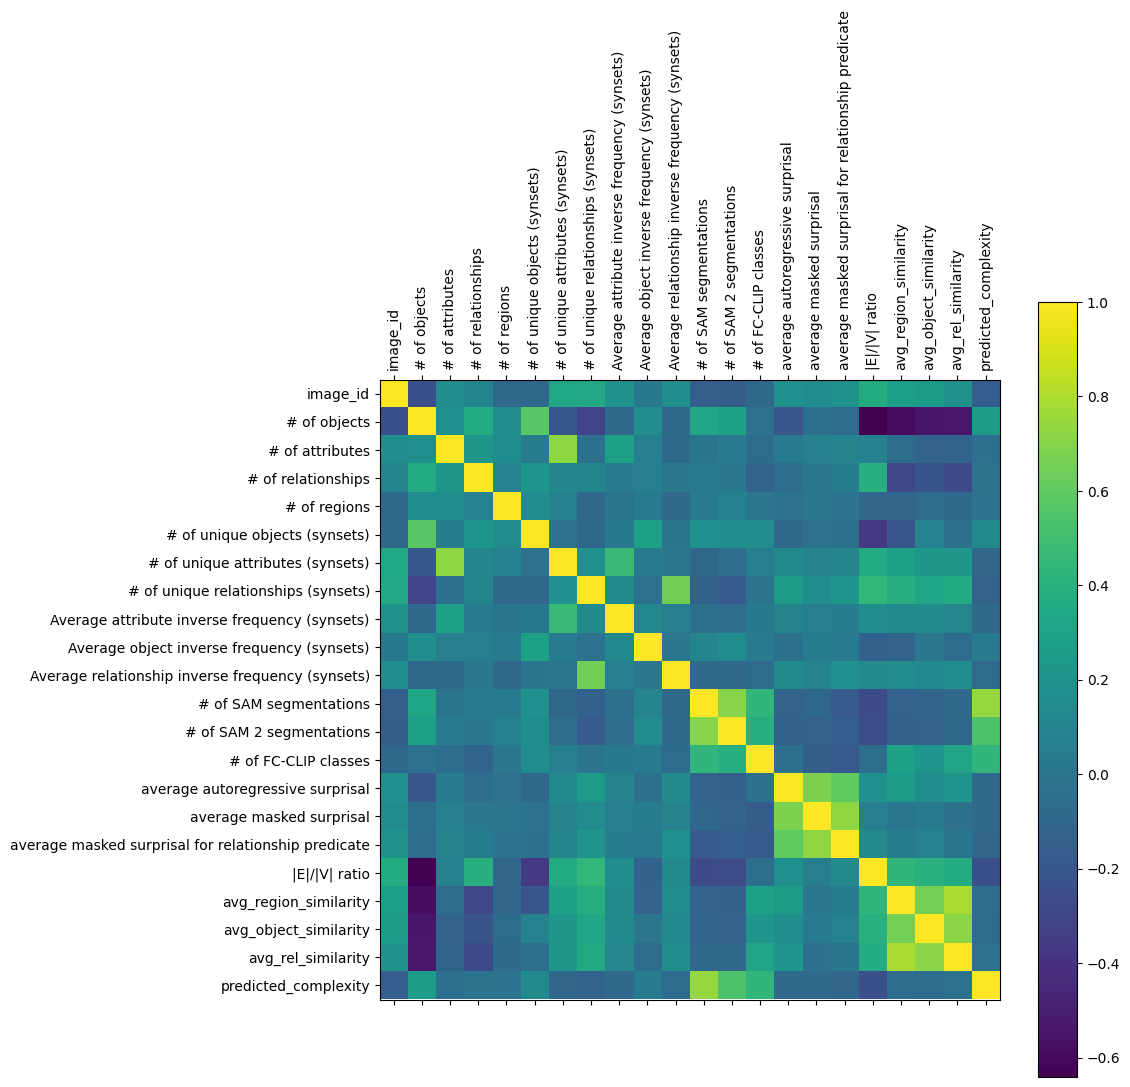

In [20]:
# read features.csv

features = pd.read_csv('features.csv')
# get only the images in keep_images_strict
features_filtered = features[features['image_id'].isin(keep_images_influence)]

# get correlation heatmap
features_filtered["avg_object_similarity"] *= -1
features_filtered["avg_region_similarity"] *= -1
features_filtered["avg_rel_similarity"] *= -1

corr = features_filtered.corr(method='spearman')
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()

In [3]:
# read images from filtered_images.txt

with open('filtered_images.txt', 'r') as f:
    filtered_images = f.readlines()
    filtered_images = [int(x.strip()) for x in filtered_images]
keep_images_influence = filtered_images

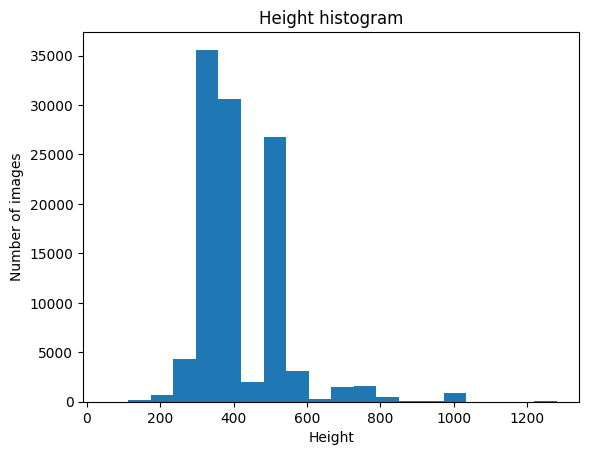

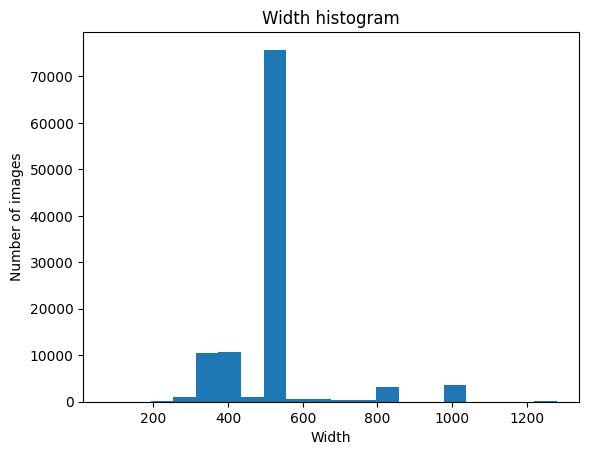

Height: [(500, 25993), (375, 24431), (333, 18899), (332, 3477), (334, 3471)]
Width: [(500, 75440), (375, 8037), (333, 5542), (1024, 3501), (800, 3190)]


: 

In [ ]:
# width = 500
# height = 500, 375, 333

h = []
w = []
for im in keep_images_influence:
    det = vg.get_image(im)
    h.append(det.height)
    w.append(det.width)

# histogram
plt.hist(h, bins=20)
plt.xlabel('Height')
plt.ylabel('Number of images')
plt.title('Height histogram')
plt.show()

# histogram for width
plt.hist(w, bins=20)
plt.xlabel('Width')
plt.ylabel('Number of images')
plt.title('Width histogram')
plt.show()

# print the first most occurring with frequencies
from collections import Counter
print("Height:", Counter(h).most_common(5))
print("Width:", Counter(w).most_common(5))
